<a href="https://colab.research.google.com/github/omerhac/arc_challenge/blob/master/arc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import json
from google.cloud import storage
from matplotlib import pyplot as plt

# Load data


In [0]:
## get paths
GCS_PATH = "gs://kds-d3cfb3d523ca35d2517017a78110126404d01fdea69417ce49950459"
training_filenames = tf.io.gfile.glob(GCS_PATH + "/training/*")
test_filenames = tf.io.gfile.glob(GCS_PATH + "/test/*")

In [0]:
# create dataset with filenames
training_dataset = tf.data.Dataset.list_files(training_filenames)

In [0]:
# load the jsons
def load_task(filename):
  task_json = tf.io.read_file(filename)
  return task_json

training_dataset = training_dataset.map(load_task)
training_dataset_numpy = tf.data.Dataset.as_numpy_iterator(training_dataset) # convert to numpy iterator

In [0]:
## create a numpy array of tasks (n_tasks, )
training_tasks = []
for task in training_dataset_numpy:
  training_tasks.append(json.loads(task))

training_tasks = np.stack(training_tasks)

## Utility functions

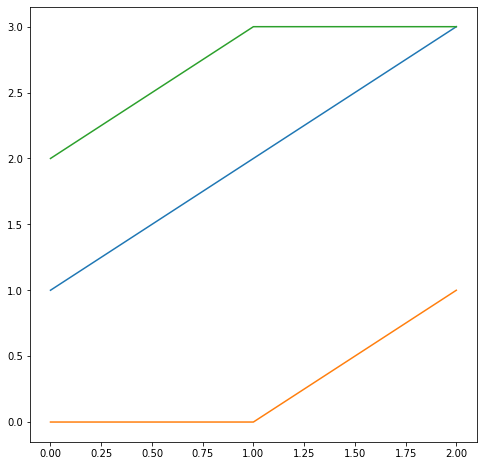

In [42]:
def print_board(board):
  plt.figure(figsize=(8,8))
  plt.plot(board)

print_board([[1, 0, 2], [2, 0, 3], [3, 1, 3]])